In [12]:
import numpy as np

import statsmodels.api as sm

from fbprophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

In [2]:
# пример данных
data = sm.datasets.co2.load_pandas()
df = data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


<AxesSubplot:>

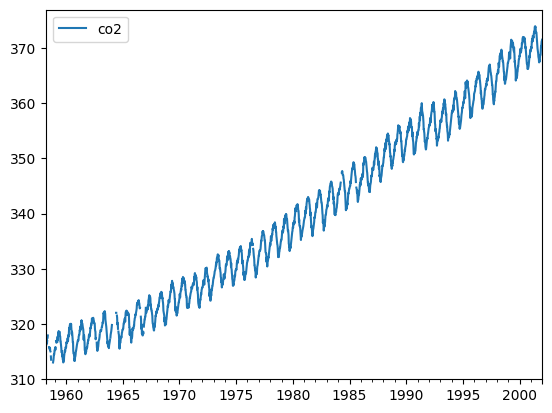

In [3]:
df.plot()

In [4]:
df_prophet  = df.reset_index()
df_prophet.columns = ['ds', 'y']

In [ ]:
m = Prophet()
m.fit(df_prophet)

In [39]:
predictions = 365*3
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

In [40]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_prophet.set_index('ds'))

cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

In [41]:
# функция для визуализации построенного прогноза
def show_forecast(cmp_df, num_predictions, num_values):
    # верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        #marker=dict(color="444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    # прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    # нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        #marker=dict(color="444"),
        line=dict(width=0),
        mode='lines')

    # фактические значения
    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        #marker=dict(color="red"),
        mode='lines',
    )

    # последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='value'),

        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)


In [44]:
show_forecast(cmp_df, predictions, 2000)

In [45]:
from fbprophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model